# End of Epoch Simulations

Here are some simulations for how the end of the epoch will go. Here are some basic assumptions present here.
1. All active traders are a part of this competition, i.e. they are going to pay an optimal amount in fees for rewards.
2. Traders can be modeled as updating their expectation for the overall market summed trader score by using their old estimate of the total score and performing a learning update that incorporates a new estimate with their old estimate. In other words, we can model each participant as updating their expectations in parallel as the epoch draws to a close.
3. The overal market participants' distribution of open interest follows an exponential distribution. This is an approximation, and in fact exponential distributions don't have quite fat enough of a tail in order to work here.
4. Rational agents have access to infinite money. That is, they may adjust their fee-paying schedule to spend more than the amount they have in their collateral account. Practically, this is probably not the case. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sympy as sp

In [2]:
# amount of DyDx given out as a reward
R = 3_835_616 

# price of DyDx
p = 20.6

# learning rate; set this to a small number so that we can converge to a solution for f_opt_mkt
# the particular value doesn't matter too much
alpha = .01

def cur_mkt_score(ds, fs, gs):
    """
    Given a bunch of participants' open-interests and fees,
    calculate the total current market score.
    """
    total = 0
    for d, f, g in zip(ds, fs, gs):
        total += (d**.28) * (f**.67) * (g**0.05)
    return total

def dist(v1, v2):
    """
    Root-mean-squared-error between vector 1 and vector 2
    """
    return (sum([(v1[i]-v2[i])**2 for i in range(len(v1))])/len(v1))**(1/2)


In [143]:
f = sp.Symbol('f')
d = sp.Symbol('d')
T = sp.Symbol('T')
g = sp.Symbol('g')

profit_below = R * p * d**0.28 * f**0.67 * 10**0.05 / (T + d**0.28 * f**0.67 * 10**0.05) - f # Sympy diff() does not support Max() in lambdified functions
profit_above = R * p * d**0.28 * f**0.67 * g**0.05 / (T + d**0.28 * f**0.67 * g**0.05) - f

profit_below_prime = sp.diff(profit_below, f)
profit_below_prime_prime = sp.diff(profit_below_prime, f)

profit_below_prime_fast = sp.lambdify([f, d, g, T], profit_below_prime, "numpy")
profit_below_prime_prime_fast = sp.lambdify([f, d, g, T], profit_below_prime_prime, "numpy")

profit_above_prime = sp.diff(profit_above, f)
profit_above_prime_prime = sp.diff(profit_above_prime, f)

profit_above_prime_fast = sp.lambdify([f, d, g, T], profit_above_prime, "numpy")
profit_above_prime_prime_fast = sp.lambdify([f, d, g, T], profit_above_prime_prime, "numpy")

In [172]:
def get_d_mkt(D, n):
    whales = np.array(range(500, 600, 10))
    d_mkt = np.array(np.random.dirichlet(np.append(whales, np.ones(n-10)), 1).ravel() * D) 
    return d_mkt

def get_g_mkt(G, n):
    whales = np.array(range(10000, 10100, 10))
    g_mkt = np.array(np.random.dirichlet(np.append(whales, np.ones(n-10)), 1).ravel() * G) 
    return g_mkt
    
def find_equilibrium(D, G=1_000_000, n=None):
    """
    Warning: If leaning rate is too small or fees vector is initialized at very high values, 
    Newton's method can update fees as negative values. This will crash the algorithm. 
    To avoid this, lower the learning rate or instantiate the fees vector at smaller amounts.
    """
    if not n:
        n = random.choice(range(1000, 5000))
    d_mkt = get_d_mkt(D, n)
    g_mkt = get_g_mkt(G, n)

    # d_mkt = np.random.exponential(scale=(D/n), size=n)
    f_mkt = np.random.rand(n)*((1/25) * D)/n

    zipped = zip(f_mkt, d_mkt, g_mkt)
    below = np.array([x for x in zipped if x[2] <= 10])
    above = np.array([x for x in zipped if x[2] > 10])
    
    # simulate_market_optimal_fee_discovery, running until convergence
    rmses = [] # the distances between fees on successive iterations of the algorithm; should tend to 0 as f_mkt convergest
    while (rmses==[]) or (rmses[-1] > 10**-10):
        mkt_score = cur_mkt_score(d_mkt, f_mkt, g_mkt)
        T_mkt = mkt_score - f_mkt**0.67 * d_mkt**0.28 * g_mkt ** 0.05
        print(below)
        d1_above = profit_above_prime_fast(*above, T_mkt)
        d1_below = profit_below_prime_fast(*below, T_mkt)
        
        d2_above = profit_above_prime_prime_fast(*above, T_mkt)
        d2_below = profit_below_prime_prime_fast(*below, T_mkt)

        d1 = np.append(d1_below, d1_above)
        d2 = np.append(d2_below, d2_above)

        unzipped = np.append(below, above)
        unzipped = list(zip(*unzipped))

        f_mkt, d_mkt, g_mkt = unzipped

        new_f_mkt = f_mkt - alpha * d1 / d2
        rmses.append(dist(new_f_mkt, f_mkt))
        f_mkt = new_f_mkt
    
    return d_mkt, f_mkt, g_mkt

In [173]:
open_interest = 1_400_000_000
results = dict()
tmp = dict()
for trial in range(10):
    print(trial)
    d_mkt, f_mkt, g_mkt = find_equilibrium(open_interest, G=5000)
    if not np.isnan(f_mkt).any():
        tmp[trial] = sorted(list(zip(d_mkt, g_mkt, f_mkt)), key=lambda x : x[1]) 
        results[trial] = sorted(list(zip(d_mkt**0.28 * g_mkt**0.05, f_mkt**0.33)), key=lambda x : x[1]) 

# for G in [10_000, 50_000, 250_000, 1_250_000, 6_000_000, 30_000_000, 150_000_000]:
#     print(G)
#     d_mkt, f_mkt, g_mkt = find_equilibrium(open_interest, G=G, n=5000)
#     if not np.isnan(f_mkt).any():
#         tmp[G] = sorted(list(zip(d_mkt, g_mkt, f_mkt)), key=lambda x : x[1]) 
#         results[G] = sorted(list(zip(d_mkt**0.28 * g_mkt**0.05, f_mkt**0.33)), key=lambda x : x[1]) 

0


ValueError: operands could not be broadcast together with shapes (4288,) (4292,) 

In [ ]:
ratios = dict()
for k, v in tmp.items():
    n = len(v)
    ratio = sum([x[2]**0.33/(x[0]**0.28*x[1]**0.05) for x in v]) / n
    expected = (0.67 * R * p)**(0.33) / (sum([x[0] for x in v])**0.28 * sum([x[1] for x in v])**0.05)
    ratios[k] = (ratio, expected)

{key:ratios[key] for key in sorted(ratios.keys())}

{0: (0.5702486496001925, 0.5469285668087245)}

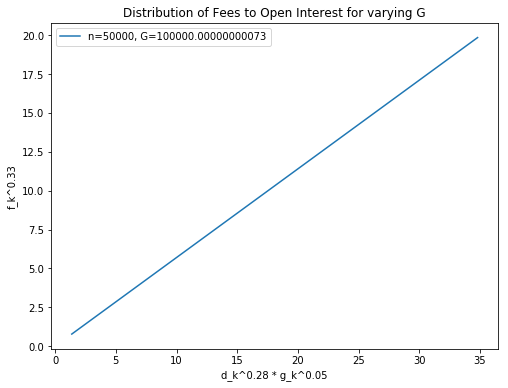

In [90]:
plt.figure(figsize=(8, 6))
for k,v in results.items():
    n = len(v)
    plt.plot(*zip(*v), label=f"n={n}, G={sum([x[1] for x in tmp[k]])}")
plt.legend()
plt.xlabel("d_k^0.28 * g_k^0.05")
plt.ylabel("f_k^0.33")
plt.title("Distribution of Fees to Open Interest for varying G")
# plt.savefig("fees_distribution_varying_G.png")
plt.show() # Illustration of how there is a steady state equilibrium, but it is different for different total open interests. I just can't figure out how to find it.

In [69]:
# Proof this actually did solve the problem
for k, v in results.items():
    f_mkt = np.array([x[1] for x in v])
    d_mkt = np.array([x[0] for x in v])
    mkt_score = cur_mkt_score(d_mkt, f_mkt)
    T_mkt = mkt_score - f_mkt**0.7 * d_mkt**0.3
    err = profit_prime_fast(f_mkt, d_mkt, T_mkt) # Verify first derivative is 0 at equilibrium for all participants
    if not np.all((err <= 10e-2)):
        raise Exception("Newton's method did not find an equilibrium.")

In [20]:
# The amount paid in fees is always the same?
for k, v in results.items():
    f_mkt = np.array([x[1] for x in v])
    print(sum(f_mkt))

55296717.83607819
55261466.42833472
55287785.79417184
55271533.077852674
55297554.0622152
55291209.83051242
55276460.14237332
55295057.6482441
55296394.84738844
